- recent update: 24.11.12
- update content:
    1. Sequence 별로 데이터 나누기
- target var: 5min return at best class (class: 4)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
import seaborn as sns
from tqdm import tqdm
import pickle
import os
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [3]:
#!pip install optuna
#!pip install optuna optuna-integration[pytorch_lightning]
#!pip install torch_optimizer

In [4]:
# display max
#pd.set_option('display.max_rows', 90)
#pd.options.display.max_columns = None

# 기본 설정으로 되돌리기
#pd.reset_option('display.max_columns')

In [5]:
# pkl 파일 불러오기
old_pkl_path = '/content/drive/MyDrive/eunsung/data/df_processed_month3_1m5m_maxreturn.pkl' # 이전 데이터
new_pkl_path = '/content/drive/MyDrive/eunsung/data/df_processed_2024_03_07to10.pkl' # 새로운 데이터

df_old = pd.read_pickle(old_pkl_path)
df_new = pd.read_pickle(new_pkl_path)
print("Data loaded from pkl file.")

Data loaded from pkl file.


In [6]:
col_old= list(df_old.columns)
col_new = list(df_new.columns)

# 각 리스트를 집합으로 변환
set_old = set(col_old)
set_new = set(col_new)

# 각 리스트에만 포함된 고유한 컬럼 찾기
unique_in_old = set_old - set_new  # col_old에만 있는 컬럼
unique_in_new = set_new - set_old  # col_new에만 있는 컬럼

# 결과 출력
print("Only in col_origin:", list(unique_in_old))
print("Only in col_new:", list(unique_in_new))
print(f"새로운 컬럼 수: {len(unique_in_new)}")

Only in col_origin: []
Only in col_new: ['RSI25_midprice', '10_min_return', 'orderbook_imbalance', 'RSI3_midprice', 'return_vol_25_midprice', 'trade_volume_for_one_minute', 'return_vol_3', '10_min_return_atbest', 'return_vol_10', 'return_vol_10_midprice', 'EMA18_midprice', 'EMA4_midprice', 'return_vol_3_midprice', 'RSI25', 'RSI10', 'return_vol_25', 'EMA9_midprice', 'trade_count_for_one_minute', 'RSI10_midprice']
새로운 컬럼 수: 19


In [7]:
# 종속변수: 1_min_return, 1_min_return_atbest, 5_min_return, 5_min_return_atbest, 10_min_return, 10_min_return_atbest, mid_price_return

In [8]:
df_selected = df_new # old or new 선택

# 시간 타입으로 변경
df_selected['false.2'] = pd.to_datetime(df_selected['false.2'])

# 데이터프레임 리샘플링 - 'timestamp_column'을 타임스탬프 컬럼 이름으로 변경하세요
df_selected.set_index('false.2', inplace=True)  # 타임스탬프를 인덱스로 설정
# df = df_selected.resample('10S').agg({**{'10_min_return_atbest': 'mean'}, **{col: 'mean' for col in df_selected.columns if col != '5_min_return_atbest'}})
df = df_selected.resample('5S').mean()
#df = df_selected

# 결과 확인
print(f'원본 데이터: {df_selected.shape}')
print(f'수정 데이터: {df.shape}')

df.reset_index(inplace=True)

<ipython-input-8-1a90a5cae2b3>:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df_selected.resample('5S').mean()


원본 데이터: (1899573, 105)
수정 데이터: (86246, 105)


<ipython-input-9-a23762fe009b>:13: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['mid_price_return'] = (df['mid_price'].pct_change() * 100).shift(shift_period) # mid price 10분뒤 수익률


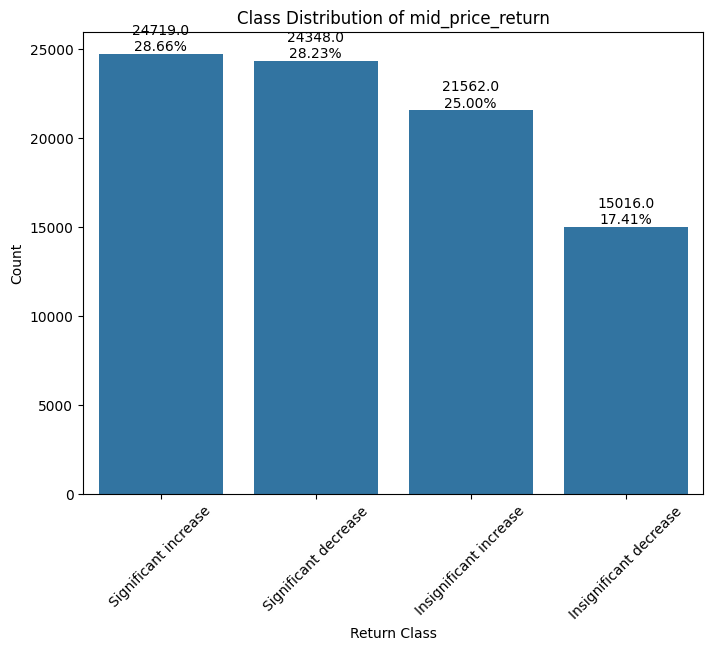

In [9]:
# 필요한 데이터 분류 작업을 진행하기 위해 종속변수 기준 설정 및 분류 함수 정의

'''
10초 단위 데이터 * 60 = 10분
1초 단위 데이터 * 600 = 10분
0.1초 단위 데이터 * 6000(10 * 600) = 10분
'''

# shift period 정의
shift_period = 600

# 새로운 종속변수 생성
df['mid_price_return'] = (df['mid_price'].pct_change() * 100).shift(shift_period) # mid price 10분뒤 수익률

target_column = 'mid_price_return'  # 종속변수 설정

# 분류 함수 정의 (논문 기준)
def classify_return(value, threshold):
    if value > threshold:
        return 'Significant increase'
    elif value < -threshold:
        return 'Significant decrease'
    elif 0 <= value <= threshold:
        return 'Insignificant increase'
    elif -threshold <= value < 0:
        return 'Insignificant decrease'
    else:
        return np.nan

# 종속변수 '1_min_return_atbest'와 '5_min_return_atbest'에 대해 분류 수행
df['target_column'] = df[target_column].apply(classify_return, threshold=0.002) # threshold: 0.002

# 클래스별 분포 시각화 (개수 + 비율)
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='target_column', order=['Significant increase', 'Significant decrease', 'Insignificant increase', 'Insignificant decrease'])
plt.title(f"Class Distribution of {target_column}")
plt.xlabel("Return Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# 전체 개수 계산
total_count = len(df)

# 각 클래스별 개수와 비율을 막대 위에 표시
for p in ax.patches:
    count = p.get_height()  # 각 막대의 개수
    percentage = f'{count / total_count * 100:.2f}%'  # 비율 계산
    ax.annotate(f'{count}\n{percentage}',
                (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom')

plt.show()


In [10]:
# 종속 변수(1_min_return, 5_min_return) 데이터프레임에서 제거
df = df.drop(['1_min_return', '1_min_return_atbest', '5_min_return', '5_min_return_atbest', '10_min_return', '10_min_return_atbest', 'mid_price_return'], axis=1)

# 수치형 데이터만 추출하여 NaN과 무한대 값 확인
numeric_df = df.select_dtypes(include=[np.number])

# NaN 값이 있는지 확인
print("NaN counts per column:")
print(df.isna().sum().any())

# 무한대 값이 있는지 확인
print("Infinite values counts per column:")
print(np.isinf(numeric_df).sum().any())

# NaN 또는 무한대 값이 있다면 제거
#df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

NaN counts per column:
True
Infinite values counts per column:
False


In [11]:
# 종속변수 라벨을 4개의 클래스(0, 1)로 변환
label_mapping = {'Significant increase': 0, 'Significant decrease': 1,
                 'Insignificant increase': 2, 'Insignificant decrease': 3}

# 종속변수 설정
df['target_column'] = df['target_column'].map(label_mapping)

# 학습(train), 검증(validation), 테스트(test) 데이터를 시간 순서에 따라 분할
train_size = int(len(df) * 0.6)
valid_size = int(len(df) * 0.2)
test_size = len(df) - train_size - valid_size

# 시간 순서에 따라 분할
train_data = df[:train_size]
valid_data = df[train_size:train_size + valid_size]
test_data = df[train_size + valid_size:]

# 결과 확인
print(f"Train set size: {train_data.shape}")
print(f"Validation set size: {valid_data.shape}")
print(f"Test set size: {test_data.shape}")


Train set size: (51371, 101)
Validation set size: (17123, 101)
Test set size: (17125, 101)


In [12]:
# 제외할 열 설정
drop_cols = ['false.2', 'target_column']
train_features = train_data.drop(columns=drop_cols)
valid_features = valid_data.drop(columns=drop_cols)
test_features = test_data.drop(columns=drop_cols)

train_labels = train_data['target_column'].values
valid_labels = valid_data['target_column'].values
test_labels = test_data['target_column'].values

# StandardScaler를 사용하여 데이터 표준화
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)
test_features_scaled = scaler.transform(test_features)

# 표준화된 데이터를 DataFrame으로 변환 (시퀀스 생성을 위해)
train_features_scaled = pd.DataFrame(train_features_scaled, columns=train_features.columns)
valid_features_scaled = pd.DataFrame(valid_features_scaled, columns=valid_features.columns)
test_features_scaled = pd.DataFrame(test_features_scaled, columns=test_features.columns)

# 시퀀스 생성 함수
def create_sequences(data, labels, sequence_length):
    sequences = []
    seq_labels = []

    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length].values)
        seq_labels.append(labels[i + sequence_length - 1])  # 시퀀스의 마지막 값의 라벨 사용

    # 텐서로 변환
    sequences = torch.tensor(sequences, dtype=torch.float32)
    seq_labels = torch.tensor(seq_labels, dtype=torch.long)

    return sequences, seq_labels

# 시퀀스 길이 설정
sequence_length = 10  # 필요에 따라 시퀀스 길이 조정

# 시퀀스 및 라벨 생성
train_sequences, train_seq_labels = create_sequences(train_features_scaled, train_labels, sequence_length)
valid_sequences, valid_seq_labels = create_sequences(valid_features_scaled, valid_labels, sequence_length)
test_sequences, test_seq_labels = create_sequences(test_features_scaled, test_labels, sequence_length)

# 결과 확인
print("Train Sequences shape:", train_sequences.shape)
print("Train Labels shape:", train_seq_labels.shape)
print("Validation Sequences shape:", valid_sequences.shape)
print("Validation Labels shape:", valid_seq_labels.shape)
print("Test Sequences shape:", test_sequences.shape)
print("Test Labels shape:", test_seq_labels.shape)

<ipython-input-12-3982ec785871>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


Train Sequences shape: torch.Size([51362, 10, 99])
Train Labels shape: torch.Size([51362])
Validation Sequences shape: torch.Size([17114, 10, 99])
Validation Labels shape: torch.Size([17114])
Test Sequences shape: torch.Size([17116, 10, 99])
Test Labels shape: torch.Size([17116])


In [13]:
# TensorDataset으로 결합
train_dataset = TensorDataset(train_sequences, train_seq_labels)
valid_dataset = TensorDataset(valid_sequences, valid_seq_labels)
test_dataset = TensorDataset(test_sequences, test_seq_labels)

# DataLoader 생성
batch_size = 128  # 배치 크기 증가
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### LSTM 모델

In [14]:
# 모델 정의 - Residual Connection 및 다층 Fully Connected 레이어 추가
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMClassifier, self).__init__()

        self.hidden_size = hidden_size

        # 첫 번째 LSTM 레이어 (입력층)
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1,
                             batch_first=True, bidirectional=True, dropout=dropout)

        # 두 번째 LSTM 레이어 (Residual Connection 사용)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=1,
                             batch_first=True, bidirectional=True, dropout=dropout)

        # 세 번째 LSTM 레이어 (Residual Connection 사용)
        self.lstm3 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=1,
                             batch_first=True, bidirectional=True, dropout=dropout)

        # Fully Connected 레이어 (Batch Normalization 및 드롭아웃 포함)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.bn1 = nn.BatchNorm1d(hidden_size * 4)

        self.fc2 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size * 2)

        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.fc4 = nn.Linear(hidden_size, output_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 첫 번째 LSTM 레이어
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # Bidirectional이므로 num_layers * 2
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm1(x, (h0, c0))

        # 두 번째 LSTM 레이어와 Residual Connection
        h1 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c1 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out_residual, _ = self.lstm2(out, (h1, c1))
        out = out + out_residual  # Residual Connection

        # 세 번째 LSTM 레이어와 Residual Connection
        h2 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c2 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out_residual2, _ = self.lstm3(out, (h2, c2))
        out = out + out_residual2  # Second Residual Connection

        # Fully Connected 레이어 통과 (Batch Normalization 및 Dropout 포함)
        out = out[:, -1, :]  # 마지막 time step의 출력값 사용

        out = self.fc1(out)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = torch.relu(out)
        out = self.dropout(out)

        # 최종 출력층
        out = self.fc4(out)

        return out

In [15]:
# # GPU 장치 설정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # 하이퍼파라미터 설정
# input_size = train_sequences.shape[2]  # 입력 특징 수 (피처 개수)
# hidden_size = 256  # LSTM 숨겨진 노드 수
# num_layers = 6  # LSTM 레이어 수
# output_size = 4  # 출력 클래스 수
# learning_rate = 0.00001  # 학습률 감소
# dropout = 0.6  # 드롭아웃 비율 증가

# # 모델 가중치 초기화 함수
# def initialize_weights(model):
#     for layer in model.modules():
#         if isinstance(layer, (nn.Linear, nn.Conv2d)):
#             nn.init.kaiming_uniform_(layer.weight)  # He initialization (ReLU 계열에 적합)
#             if layer.bias is not None:
#                 nn.init.constant_(layer.bias, 0)
#         elif isinstance(layer, nn.LSTM):
#             for name, param in layer.named_parameters():
#                 if 'weight' in name:
#                     nn.init.xavier_uniform_(param)  # Xavier 초기화
#                 elif 'bias' in name:
#                     nn.init.constant_(param, 0)

# # 모델 생성
# model = ImprovedLSTMClassifier(input_size, hidden_size, num_layers, output_size, dropout).to(device)

# # 가중치 초기화 호출
# initialize_weights(model)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # AdamW 옵티마이저 사용
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 학습률 스케줄러 추가

# # 학습 및 검증 손실 저장 리스트
# train_losses = []
# valid_losses = []

# # 학습 루프
# num_epochs = 40
# best_valid_loss = float('inf')

# for epoch in range(num_epochs):
#     # 1. 훈련 단계
#     model.train()
#     train_loss = 0
#     for features, labels in train_loader:
#         features, labels = features.to(device), labels.to(device)
#         optimizer.zero_grad()

#         outputs = model(features)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # 2. 검증 단계
#     model.eval()
#     valid_loss = 0
#     with torch.no_grad():
#         for features, labels in valid_loader:
#             features, labels = features.to(device), labels.to(device)
#             outputs = model(features)
#             loss = criterion(outputs, labels)
#             valid_loss += loss.item()

#     valid_loss /= len(valid_loader)
#     valid_losses.append(valid_loss)

#     # 학습률 스케줄러 업데이트
#     scheduler.step()

#     # 검증 손실이 개선되었는지 확인 후 모델 저장
#     if valid_loss < best_valid_loss:
#         best_valid_loss = valid_loss
#         best_epoch = epoch
#         torch.save(model.state_dict(), "best_lstm_model.pth")
#         print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")

#     # 에포크별 손실 출력
#     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# # 손실 시각화
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Train vs Validation Loss')
# plt.show()

In [16]:
# def initialize_weights(model):
#     for layer in model.modules():
#         if isinstance(layer, (nn.Linear, nn.Conv2d)):
#             nn.init.kaiming_uniform_(layer.weight)  # He initialization (ReLU 계열에 적합)
#             if layer.bias is not None:
#                 nn.init.constant_(layer.bias, 0)
#         elif isinstance(layer, nn.LSTM):
#             for name, param in layer.named_parameters():
#                 if 'weight' in name:
#                     nn.init.xavier_uniform_(param)  # Xavier 초기화
#                 elif 'bias' in name:
#                     nn.init.constant_(param, 0)

# # 가중치 초기화 호출
# initialize_weights(model)

In [18]:
# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 학습 및 평가 함수
def objective(trial):
    # Optuna에서 하이퍼파라미터 선택
    hidden_size = trial.suggest_int("hidden_size", 64, 512, step=64)
    num_layers = trial.suggest_int("num_layers", 1, 6)
    dropout = trial.suggest_float("dropout", 0.2, 0.7)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # 옵티마이저 선택 (AdamW, RAdam, AdaBelief 중 하나)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RAdam", "AdaBelief"])

    # 모델, 손실 함수 및 옵티마이저 설정
    model = LSTMClassifier(input_size=train_sequences.shape[2],
                                   hidden_size=hidden_size,
                                   num_layers=num_layers,
                                   output_size=4,
                                   dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "RAdam":
        optimizer = optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        from torch_optimizer import AdaBelief  # 별도 설치 필요
        optimizer = AdaBelief(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # 학습률 스케줄러 선택 (StepLR 또는 ReduceLROnPlateau)
    scheduler_type = trial.suggest_categorical("scheduler", ["StepLR", "ReduceLROnPlateau"])
    if scheduler_type == "StepLR":
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    else:
        scheduler = ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    # Pruner 설정
    trial.set_user_attr("epoch", 0)

    # 학습 및 검증
    num_epochs = 50  # 에포크 수 증가
    best_precision = 0.0  # 최고 precision 기록
    patience = 8  # early stopping patience
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if scheduler_type == "StepLR":
            scheduler.step()
        else:
            # ReduceLROnPlateau의 경우 매 epoch의 검증 결과에 따라 scheduler를 업데이트
            scheduler.step(best_precision)

        # 검증 단계 - significant increase (label 0)에 대한 precision 계산
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for features, labels in valid_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # 다중 클래스에 맞게 macro 평균으로 precision 계산
        precision = precision_score(all_labels, all_preds, labels=[0], average="macro", zero_division=0)

        # Optuna Pruner 적용
        trial.report(precision, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Early stopping 조건 확인
        if precision > best_precision:
            best_precision = precision
            early_stop_counter = 0  # 최상의 성능일 때 카운터 초기화
            torch.save(model.state_dict(), "best_lstm_model.pth")  # 모델 가중치 저장
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return best_precision

# Optuna 스터디 설정 및 하이퍼파라미터 최적화 실행
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Precision: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-12 09:31:18,759] A new study created in memory with name: no-name-9ae06a0f-2dc5-40d2-a2db-c316ae0cd8c9


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2124223766302173 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:32:14,491] Trial 0 finished with value: 0.28330350294042445 and parameters: {'hidden_size': 320, 'num_layers': 1, 'dropout': 0.2124223766302173, 'learning_rate': 1.4403893914548082e-05, 'weight_decay': 1.827394321125491e-05, 'optimizer': 'RAdam', 'scheduler': 'StepLR'}. Best is trial 0 with value: 0.28330350294042445.


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3101766992931352 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:33:16,261] Trial 1 finished with value: 0.3056768558951965 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.3101766992931352, 'learning_rate': 8.949961154349396e-05, 'weight_decay': 5.095592610742218e-05, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.3056768558951965.


Early stopping at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.550201331170995 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:34:30,351] Trial 2 finished with value: 0.2979890310786106 and parameters: {'hidden_size': 320, 'num_layers': 2, 'dropout': 0.550201331170995, 'learning_rate': 5.273555325105141e-05, 'weight_decay': 9.93279216407958e-05, 'optimizer': 'RAdam', 'scheduler': 'ReduceLROnPlateau'}. Best is trial 1 with value: 0.3056768558951965.


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5875491078421211 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:35:41,077] Trial 3 finished with value: 0.28022417934347477 and parameters: {'hidden_size': 256, 'num_layers': 5, 'dropout': 0.5875491078421211, 'learning_rate': 8.172985626755182e-05, 'weight_decay': 3.1118389666680713e-05, 'optimizer': 'AdamW', 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.3056768558951965.


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28313998915068805 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:37:21,141] Trial 4 finished with value: 0.2854155776267642 and parameters: {'hidden_size': 192, 'num_layers': 2, 'dropout': 0.28313998915068805, 'learning_rate': 2.659843758426108e-05, 'weight_decay': 4.9730992316775726e-05, 'optimizer': 'AdamW', 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.3056768558951965.


Early stopping at epoch 17


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4954313816476172 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:37:25,957] Trial 5 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40096730500312294 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:38:24,110] Trial 6 finished with value: 0.30058651026392963 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.40096730500312294, 'learning_rate': 4.8407650441970236e-05, 'weight_decay': 2.5605713598626205e-06, 'optimizer': 'RAdam', 'scheduler': 'StepLR'}. Best is trial 1 with value: 0.3056768558951965.


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6177923891309776 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:39:08,957] Trial 7 finished with value: 0.308411214953271 and parameters: {'hidden_size': 448, 'num_layers': 3, 'dropout': 0.6177923891309776, 'learning_rate': 0.0005597312395891243, 'weight_decay': 3.549669304945977e-06, 'optimizer': 'RAdam', 'scheduler': 'ReduceLROnPlateau'}. Best is trial 7 with value: 0.308411214953271.


Early stopping at epoch 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3665402564636139 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:39:14,342] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4321629549403798 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:39:20,420] Trial 9 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6701755157219178 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:40:06,904] Trial 10 finished with value: 0.28735632183908044 and parameters: {'hidd

Early stopping at epoch 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6998208285519762 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:40:13,493] Trial 11 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3143798968367191 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:41:10,588] Trial 12 finished with value: 0.5 and parameters: {'hidden_size': 448, 'num_layers': 6, 'dropout': 0.3143798968367191, 'learning_rate': 0.00023465286154335702, 'weight_decay': 6.518398643352639e-06, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 12 with value: 0.5.


Early stopping at epoch 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6014443544610534 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:41:15,723] Trial 13 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5035184341769957 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:41:22,010] Trial 14 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22218172745360198 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:41:28,407] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/mo

Early stopping at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26008678228061494 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:43:56,848] Trial 19 finished with value: 0.5714285714285714 and parameters: {'hidden_size': 384, 'num_layers': 6, 'dropout': 0.26008678228061494, 'learning_rate': 0.00014282342931157258, 'weight_decay': 6.915704033001669e-06, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 19 with value: 0.5714285714285714.


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27230229620381713 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:44:53,318] Trial 20 finished with value: 0.35294117647058826 and parameters: {'hidden_size': 384, 'num_layers': 6, 'dropout': 0.27230229620381713, 'learning_rate': 0.00012266858889072287, 'weight_decay': 1.3977834692949155e-05, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 19 with value: 0.5714285714285714.


Early stopping at epoch 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2659695327144729 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:44:59,738] Trial 21 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38376985976088823 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:45:06,185] Trial 22 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3360805401269904 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:45:12,901] Trial 23 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/mo

Early stopping at epoch 10


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23689280487663913 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:47:34,574] Trial 26 finished with value: 0.3136094674556213 and parameters: {'hidden_size': 448, 'num_layers': 4, 'dropout': 0.23689280487663913, 'learning_rate': 5.986364407392211e-05, 'weight_decay': 2.1696503347439874e-05, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 19 with value: 0.5714285714285714.


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4074585024208168 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:47:39,663] Trial 27 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34973239226425945 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:47:46,262] Trial 28 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21298193364154472 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:48:43,208] Trial 29 finished with value: 0.5 and parameters: {'hidden_size': 32

Early stopping at epoch 9


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4508229415293235 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:48:49,785] Trial 30 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2225327036967353 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:48:56,099] Trial 31 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20150992322469835 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:49:03,538] Trial 32 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/mo

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32545610056439966 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:50:53,739] Trial 40 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5296308206724003 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:52:09,455] Trial 41 finished with value: 0.5 and parameters: {'hidden_size': 384, 'num_layers': 3, 'dropout': 0.5296308206724003, 'learning_rate': 0.00015973594589040015, 'weight_decay': 2.5291591837164435e-06, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 19 with value: 0.5714285714285714.


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5562855957211837 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:52:16,027] Trial 42 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5260699153327565 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:53:31,790] Trial 43 finished with value: 0.38461538461538464 and parameters: {'hidden_size': 320, 'num_layers': 3, 'dropout': 0.5260699153327565, 'learning_rate': 0.00010266982368317551, 'weight_decay': 2.122875559249671e-06, 'optimizer': 'AdaBelief', 'scheduler': 'StepLR'}. Best is trial 19 with value: 0.5714285714285714.


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5750833790806587 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:53:38,020] Trial 44 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4730996985960611 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:53:44,232] Trial 45 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4194126767308808 and num_layers=1
  warnings.warn(
[I 2024-11-12 09:53:50,830] Trial 46 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/mod

Best trial:
  Precision: 0.5714285714285714
  Params:
    hidden_size: 384
    num_layers: 6
    dropout: 0.26008678228061494
    learning_rate: 0.00014282342931157258
    weight_decay: 6.915704033001669e-06
    optimizer: AdaBelief
    scheduler: StepLR


In [28]:
import torch.nn.init as init

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
        init.xavier_uniform_(m.weight.data)  # Xavier 초기화
        if m.bias is not None:
            init.constant_(m.bias.data, 0)  # 바이어스를 0으로 초기화

# Optuna로 찾은 최적의 하이퍼파라미터로 모델 초기화
best_hyperparameters = study.best_trial.params
best_hidden_size = best_hyperparameters['hidden_size']
best_num_layers = best_hyperparameters['num_layers']
best_dropout = best_hyperparameters['dropout']
best_learning_rate = best_hyperparameters['learning_rate']
best_weight_decay = best_hyperparameters['weight_decay']

# LSTM 모델 초기화
best_model = LSTMClassifier(
    input_size=train_sequences.shape[2],
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    output_size=4,
    dropout=best_dropout
).to(device)

# 가중치 초기화 호출
initialize_weights(best_model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(best_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)  #
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 학습률 스케줄러 추가

# 학습 및 검증 손실 저장 리스트
train_losses = []
valid_losses = []

# 학습 루프
num_epochs = 40
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    # 1. 훈련 단계
    best_model.train()
    train_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = best_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 2. 검증 단계
    best_model.eval()
    valid_loss = 0
    with torch.no_grad():
        for features, labels in valid_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = best_model(features)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 검증 손실이 개선되었는지 확인 후 모델 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoch
        torch.save(best_model.state_dict(), "best_lstm_model.pth")
        print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")

    # 에포크별 손실 출력
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

# 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26008678228061494 and num_layers=1
  warnings.warn(


Model saved at epoch 1 with validation loss 1.5101
Epoch [1/40], Train Loss: 1.4150, Valid Loss: 1.5101
Epoch [2/40], Train Loss: 1.3912, Valid Loss: 1.5821
Epoch [3/40], Train Loss: 1.3809, Valid Loss: 1.5842
Epoch [4/40], Train Loss: 1.3719, Valid Loss: 1.6514
Epoch [5/40], Train Loss: 1.3620, Valid Loss: 1.6861
Epoch [6/40], Train Loss: 1.3496, Valid Loss: 1.7452
Epoch [7/40], Train Loss: 1.3373, Valid Loss: 1.8713


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26008678228061494 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 1.6120, Valid Loss: 1.5700
Epoch [2/50], Train Loss: 1.4943, Valid Loss: 1.5598
Epoch [3/50], Train Loss: 1.4587, Valid Loss: 1.5439
Epoch [4/50], Train Loss: 1.4324, Valid Loss: 1.6391
Epoch [5/50], Train Loss: 1.4129, Valid Loss: 1.6042
Epoch [6/50], Train Loss: 1.3998, Valid Loss: 1.5735
Epoch [7/50], Train Loss: 1.3847, Valid Loss: 1.5220
Epoch [8/50], Train Loss: 1.3675, Valid Loss: 1.6069
Epoch [9/50], Train Loss: 1.3523, Valid Loss: 1.7265
Epoch [10/50], Train Loss: 1.3387, Valid Loss: 1.5611
Epoch [11/50], Train Loss: 1.3154, Valid Loss: 1.7541
Early stopping at epoch 12
                        precision    recall  f1-score   support

  Significant increase       0.17      0.00      0.00      5691
  Significant decrease       0.32      0.01      0.02      5847
Insignificant increase       0.18      0.95      0.30      3028
Insignificant decrease       0.16      0.05      0.07      2550

              accuracy                           0.18     17116
  

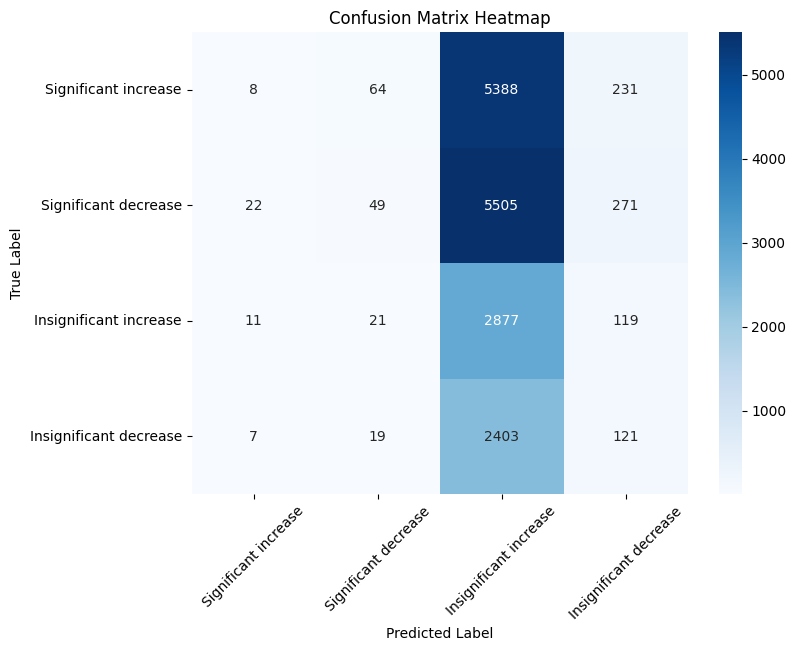

In [24]:
# 테스트 데이터셋에서 성능 평가
all_preds = []
all_labels = []

with torch.no_grad():
    best_model.eval()
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 분류 성능 평가 (정확도, 정밀도, 재현율, F1 스코어)
labels_set = [0, 1, 2, 3]
target_names = ['Significant increase', 'Significant decrease', 'Insignificant increase', 'Insignificant decrease']
report = classification_report(all_labels, all_preds, labels=labels_set, target_names=target_names, zero_division=0)
print(report)

# 정확도 계산 및 출력
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds, labels=labels_set)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xticks(rotation=45)
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
import json

# 최적의 하이퍼파라미터와 모델 구조를 JSON에 저장할 수 있도록 구성
best_hyperparameters = study.best_trial.params
model_structure = str(best_model)

# 테스트 데이터셋에서 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 테스트 성능 결과 계산
accuracy = accuracy_score(all_labels, all_preds)
classification_report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
confusion_matrix_list = confusion_matrix(all_labels, all_preds).tolist()  # JSON 저장을 위해 리스트 형태로 변환

# 모든 결과를 하나의 JSON 구조로 통합
final_results = {
    "best_hyperparameters": best_hyperparameters,
    "model_structure": model_structure,
    "test_results": {
        "accuracy": accuracy,
        "classification_report": classification_report_dict,
        "confusion_matrix": confusion_matrix_list
    }
}

# 모든 결과를 하나의 JSON 파일로 저장
with open("final_results.json", "w") as f:
    json.dump(final_results, f, indent=4)

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.

`WeightedRandomSampler`는 PyTorch에서 데이터 불균형 문제를 해결하기 위해 사용되는 샘플링 기법입니다. 데이터셋에서 각 샘플에 가중치를 부여하고, 가중치에 따라 샘플이 선택될 확률을 조정하여 데이터 로더에서 데이터를 균형 있게 제공하는 역할을 합니다.

#### 기본 원리:
- 각 클래스의 샘플 수가 불균형한 경우, `WeightedRandomSampler`는 각 샘플에 가중치를 부여합니다.
- 가중치가 큰 클래스의 샘플은 더 자주 선택되고, 가중치가 작은 클래스의 샘플은 덜 자주 선택됩니다.
- 이렇게 함으로써 모델이 훈련할 때, 각 클래스가 데이터셋에서 고르게 학습되도록 하여 __클래스 불균형 문제__를 완화할 수 있습니다.

#### 주요 파라미터:
- `weights`: 각 샘플에 부여되는 가중치입니다. 이 값은 클래스의 빈도에 반비례하여 설정되는 경우가 많습니다. 즉, 샘플 수가 적은 클래스에 더 큰 가중치를 부여하여 학습 시 자주 선택되도록 합니다.
- `num_samples`: 각 epoch에서 샘플링할 총 샘플 수를 나타냅니다. 일반적으로는 전체 샘플 수와 같게 설정합니다.
- `replacement`: `True`로 설정하면 샘플이 복원(replacement)되어 샘플링됩니다. 즉, 같은 샘플이 여러 번 선택될 수 있습니다.